In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
import torch
import torch.nn as nn
import torch.optim as optim

### Generate the XOR Dataset

In [2]:
# Step 1: Generate XOR data
def generate_xor_data(n_samples=200):
    X = np.random.uniform(-1, 1, (n_samples, 2))
    y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0).astype(int)
    return X, y

### Helper Function 

In [22]:
def plot_decision_boundary_train_test(model, X_train, y_train, X_test, y_test):
    # Create figure with 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Get grid bounds from both train and test data
    x_min = min(X_train[:, 0].min(), X_test[:, 0].min()) - 1
    x_max = max(X_train[:, 0].max(), X_test[:, 0].max()) + 1
    y_min = min(X_train[:, 1].min(), X_test[:, 1].min()) - 1
    y_max = max(X_train[:, 1].max(), X_test[:, 1].max()) + 1
    
    # Create grid for plotting decision boundaries
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    X_grid = np.c_[xx.ravel(), yy.ravel()]
    
    with torch.no_grad():
        Z = model(torch.tensor(X_grid, dtype=torch.float32)).numpy()
    
    Z = Z.reshape(xx.shape)

    # Plot decision boundary and training data
    axes[0].contourf(xx, yy, Z, alpha=0.8)
    axes[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolor='k', marker='o')
    axes[0].set_title('Train Data')
    axes[0].set_xlabel('X1')
    axes[0].set_ylabel('X2')

    # Plot decision boundary and test data
    axes[1].contourf(xx, yy, Z, alpha=0.4)
    axes[1].scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolor='k', marker='o')
    axes[1].set_title('Test Data')
    axes[1].set_xlabel('X1')
    axes[1].set_ylabel('X2')

    plt.tight_layout()
    plt.show()

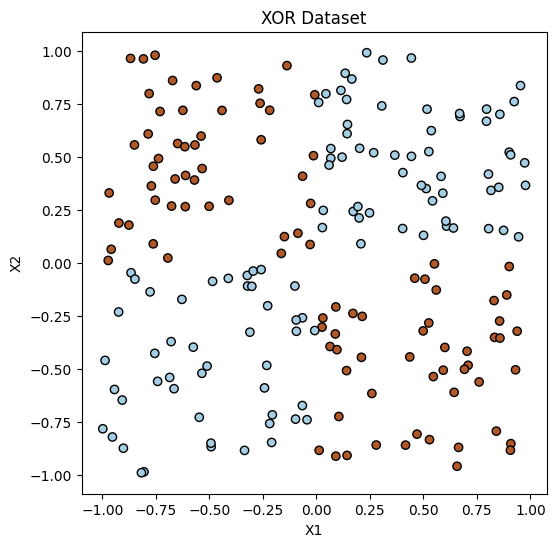

In [4]:
# Generate XOR data
X_train, y_train = generate_xor_data(200)
X_test, y_test = generate_xor_data(200)

# Plotting the dataset
plt.figure(figsize=(6,6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Paired, edgecolor='k')
plt.title('XOR Dataset')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [5]:
# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

### 

### MLP Model with Binary Cross-Entropy Loss

In [6]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2, 8)  # Input layer
        self.fc2 = nn.Linear(8, 8)  # Hidden layer
        self.fc3 = nn.Linear(8, 1)  # Output layer
        self.relu = nn.ReLU()       # Activation function
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [20]:
model = MLP()
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Optimizer

# Training loop
n_epochs = 1000
for epoch in range(n_epochs):
    model.train()
    
    # Forward pass
    outputs = model(X_train)  # Raw logits, no sigmoid applied
    loss = criterion(outputs, y_train)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print loss occasionally
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')

Epoch [100/1000], Loss: 0.1053
Epoch [200/1000], Loss: 0.0273
Epoch [300/1000], Loss: 0.0138
Epoch [400/1000], Loss: 0.0083
Epoch [500/1000], Loss: 0.0056
Epoch [600/1000], Loss: 0.0040
Epoch [700/1000], Loss: 0.0030
Epoch [800/1000], Loss: 0.0024
Epoch [900/1000], Loss: 0.0018
Epoch [1000/1000], Loss: 0.0015


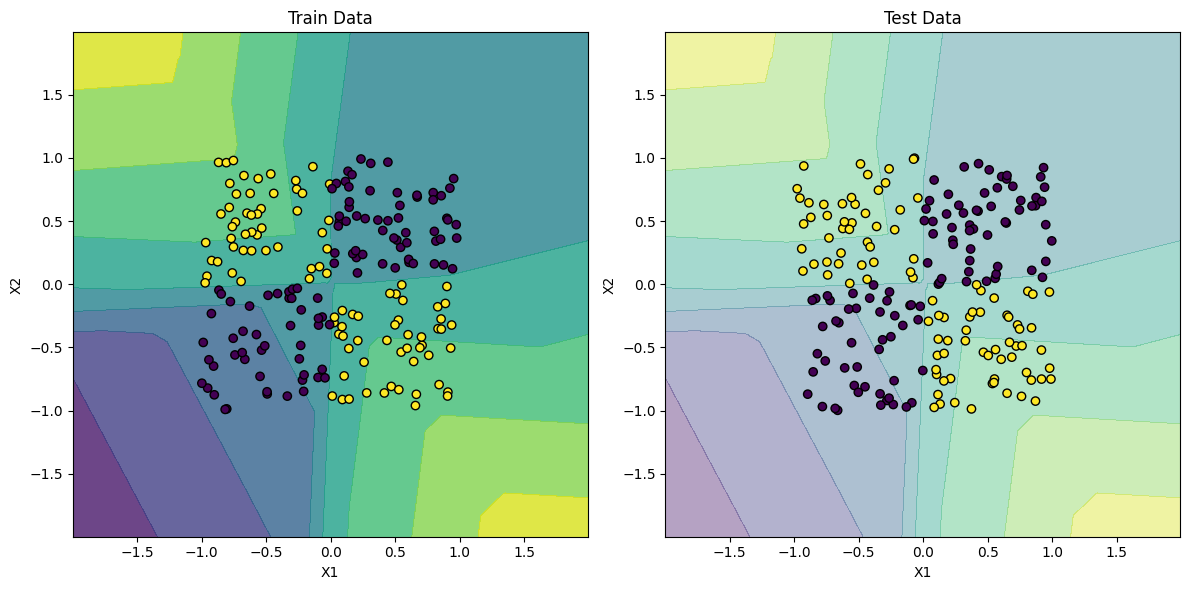

In [23]:
# Plot decision boundaries for both train and test datasets
plot_decision_boundary_train_test(model, X_train.numpy(), y_train.numpy(), X_test.numpy(), y_test.numpy())

### L1 Regularisation 

In [9]:
# Step 3: Define the L1 regularization function
def L1_penalty(model, l1_lambda):
    l1_norm = sum(p.abs().sum() for p in model.parameters() if p.requires_grad)
    return l1_lambda * l1_norm
    

In [10]:
# Step 5: Initialize the model and train with L1 regularization
model = MLP()
l1_lambda = 0.001  # You can vary this penalty coefficient
epochs = 1000

criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Optimizer

for epoch in range(epochs):
    model.train()
    
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    # Add L1 regularization to the loss
    l1_loss = L1_penalty(model, l1_lambda)
    total_loss = loss + l1_loss
    
    # Backward pass and optimization
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # Print loss occasionally
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss.item():.4f}, L1 Penalty: {l1_loss.item():.4f}')


Epoch [100/1000], Loss: 0.1531, L1 Penalty: 0.0552
Epoch [200/1000], Loss: 0.1045, L1 Penalty: 0.0675
Epoch [300/1000], Loss: 0.0957, L1 Penalty: 0.0700
Epoch [400/1000], Loss: 0.0907, L1 Penalty: 0.0692
Epoch [500/1000], Loss: 0.0864, L1 Penalty: 0.0673
Epoch [600/1000], Loss: 0.0821, L1 Penalty: 0.0659
Epoch [700/1000], Loss: 0.0783, L1 Penalty: 0.0644
Epoch [800/1000], Loss: 0.0757, L1 Penalty: 0.0633
Epoch [900/1000], Loss: 0.0740, L1 Penalty: 0.0627
Epoch [1000/1000], Loss: 0.0727, L1 Penalty: 0.0619


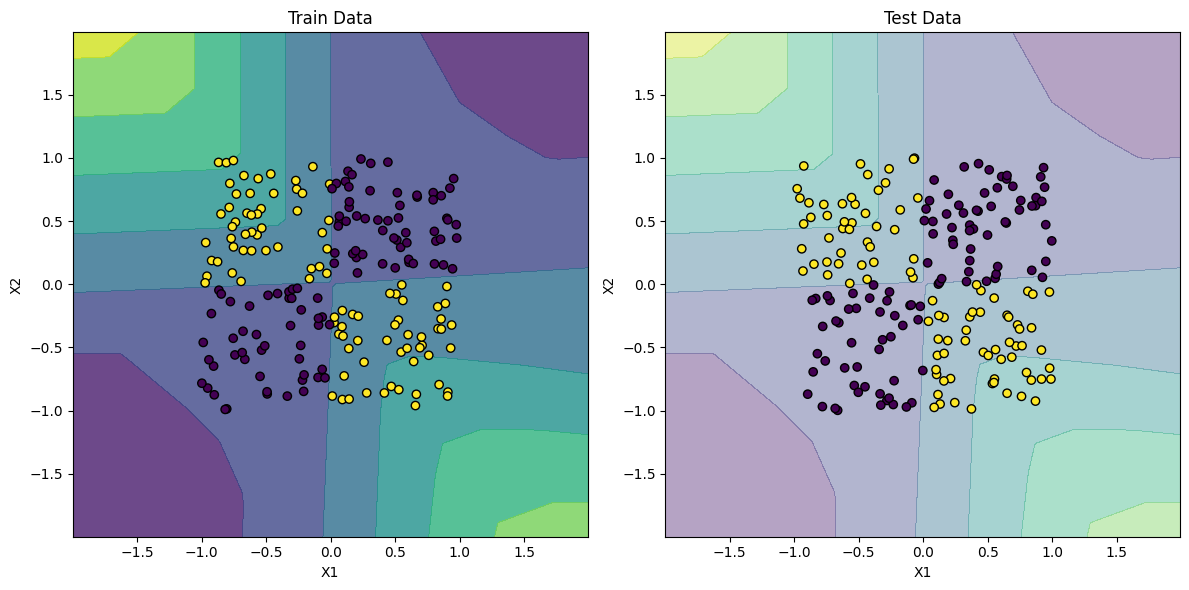

In [11]:
# Plot decision boundaries for both train and test datasets
model.eval()
plot_decision_boundary_train_test(model, X_train.numpy(), y_train.numpy(), X_test.numpy(), y_test.numpy())

### L2 Regularisation

In [12]:
# Initialize the model, loss function, and optimizer with L2 regularization (weight decay)
model = MLP()
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss with logits

# Add L2 regularization using the weight_decay parameter in Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)  # L2 regularization with weight_decay

# Training loop with L2 regularization
n_epochs = 1000
for epoch in range(n_epochs):
    model.train()
    
    # Forward pass
    outputs = model(X_train)  # Raw logits
    loss = criterion(outputs, y_train)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print loss occasionally
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')


Epoch [100/1000], Loss: 0.1322
Epoch [200/1000], Loss: 0.0503
Epoch [300/1000], Loss: 0.0367
Epoch [400/1000], Loss: 0.0318
Epoch [500/1000], Loss: 0.0289
Epoch [600/1000], Loss: 0.0275
Epoch [700/1000], Loss: 0.0265
Epoch [800/1000], Loss: 0.0259
Epoch [900/1000], Loss: 0.0255
Epoch [1000/1000], Loss: 0.0252


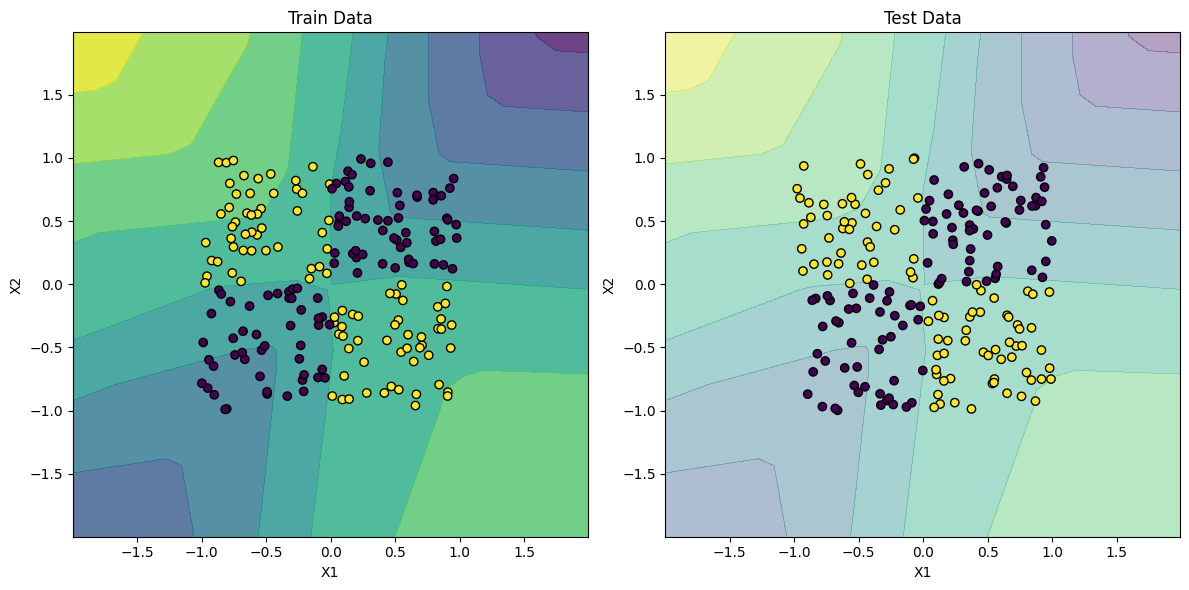

In [13]:
# Plot decision boundaries for both train and test datasets
model.eval()
plot_decision_boundary_train_test(model, X_train.numpy(), y_train.numpy(), X_test.numpy(), y_test.numpy())

### Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score

def add_polynomial_features(X, degree=2):
    poly = PolynomialFeatures(degree)
    return poly.fit_transform(X)

X_train_np = X_train.cpu().numpy()
X_test_np = X_test.cpu().numpy()
y_train_np = y_train.cpu().numpy()
y_test_np = y_test.cpu().numpy()

X_train_poly = add_polynomial_features(X_train_np, degree=2)
X_test_poly = add_polynomial_features(X_test_np, degree=2)

model = LogisticRegression()
model.fit(X_train_poly, y_train_np.ravel())


LogisticRegression()

In [17]:
import matplotlib.pyplot as plt

def plot_logistic_decision_boundary(X_train, X_test, y_train, y_test, model, title):
    # Create subplots for Train and Test data
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Define meshgrid for both subplots
    X = np.vstack([X_train, X_test])
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    
    # Generate predictions for the grid
    X_grid_poly = add_polynomial_features(np.c_[xx.ravel(), yy.ravel()])
    Z = model.predict(X_grid_poly)
    Z = Z.reshape(xx.shape)
    
    # Plot for Train Data
    ax1.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.4)
    ax1.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="viridis", s=10, label="Train")
    ax1.set_title(f"{title} - Train Data")
    ax1.set_xlabel(r"$x_1$")
    ax1.set_ylabel(r"$x_2$")
    
    # Plot for Test Data
    ax2.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.4)
    ax2.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap="viridis", s=10, alpha=0.5, label="Test")
    ax2.set_title(f"{title} - Test Data")
    ax2.set_xlabel(r"$x_1$")
    ax2.set_ylabel(r"$x_2$")
    
    # Add a common legend
    handles, labels = ax1.get_legend_handles_labels()

    plt.tight_layout()
    plt.show()


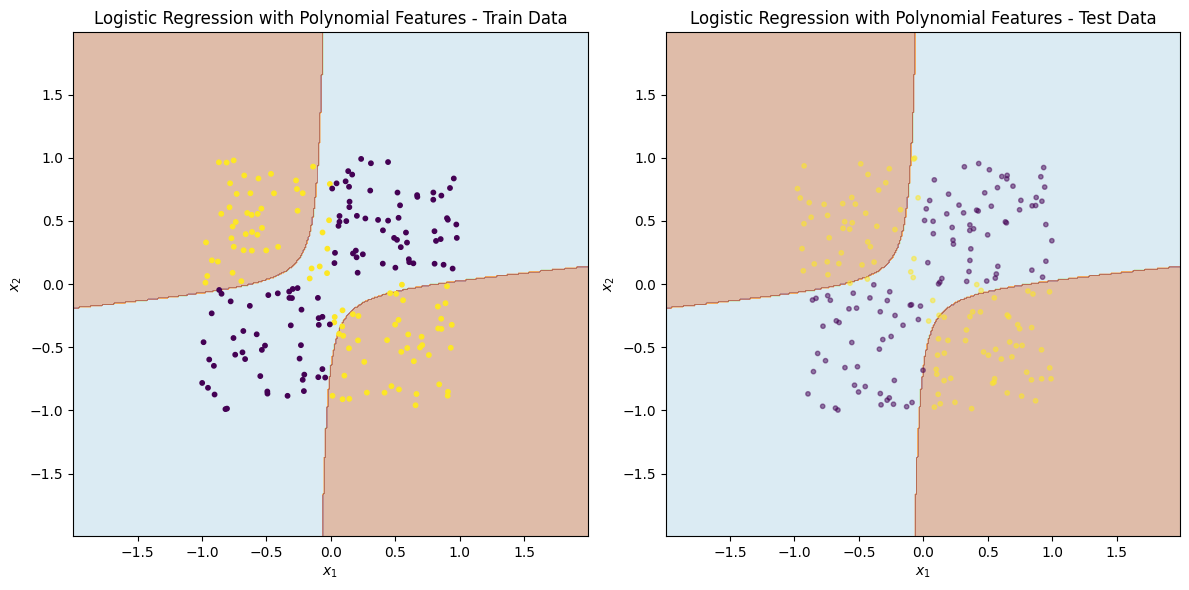

In [18]:
plot_logistic_decision_boundary(X_train_np, X_test_np, y_train_np, y_test_np, model, title="Logistic Regression with Polynomial Features")